In [1]:
# If I import the Pytorch first then it works. If I import the Tensorflow first it will give error.
import torch
torch.__version__

C:\Users\zanma\anaconda3\envs\GE\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.10.2+cpu'

In [2]:
import tensorflow as tf
tf.__version__

'2.9.1'

In [3]:
import fastestimator as fe
from fastestimator.dataset.data import mnist
from fastestimator.op.numpyop.univariate import ExpandDims, Minmax

train_data, eval_data = mnist.load_data()

pipeline = fe.Pipeline(train_data=train_data,
                       eval_data=eval_data,
                       batch_size=32,
                       ops=[ExpandDims(inputs="x", outputs="x"), Minmax(inputs="x", outputs="x")])

FastEstimator-Warn: Pipeline multiprocessing is disabled. OS must support the 'fork' start method.


In [4]:
from fastestimator.architecture.tensorflow import LeNet
# from fastestimator.architecture.pytorch import LeNet  # One can also use a pytorch model

from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp

model = fe.build(model_fn=LeNet, optimizer_fn="adam")

network = fe.Network(ops=[
        ModelOp(model=model, inputs="x", outputs="y_pred"),
        CrossEntropy(inputs=("y_pred", "y"), outputs="ce"),
        UpdateOp(model=model, loss_name="ce") 
    ])

In [5]:
from fastestimator.trace.metric import Accuracy
from fastestimator.trace.io import BestModelSaver
import tempfile

traces = [Accuracy(true_key="y", pred_key="y_pred"),
          BestModelSaver(model=model, save_dir=tempfile.mkdtemp(), metric="accuracy", save_best_mode="max")]

estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=2,
                         traces=traces)

In [6]:
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; logging_interval: 100; num_device: 0;
FastEstimator-Train: step: 1; ce: 2.3221712;
FastEstimator-Train: step: 100; ce: 0.53834504; steps/sec: 112.49;
FastEstimator-Train: step: 200; ce: 0.21255937; steps/sec: 108.09;
FastEstimator-Train: step: 300; ce: 0.093046635; steps/sec: 104.39;
FastEstimator-Train: step: 400; ce: 0.2404779; steps/sec: 114.43;
FastEstimator-Train: step: 500; ce: 0.13437817; steps/sec: 114.47;
FastEstimator-Train: step: 600; ce: 0.013130439; steps/sec: 109.1;
FastEstimator-Train: step: 700; ce: 0.18559057

Ground truth class is 7
Predicted class is 7


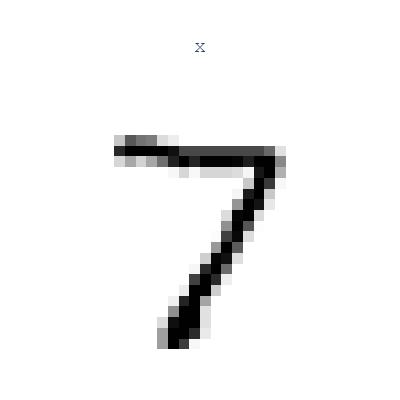

In [7]:
import numpy as np

data = eval_data[0]
data = pipeline.transform(data, mode="eval")
data = network.transform(data, mode="eval")

print("Ground truth class is {}".format(data["y"][0]))
print("Predicted class is {}".format(np.argmax(data["y_pred"])))
img = fe.util.BatchDisplay(title="x", image=data["x"])
img.show()